In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
dd=pd.read_csv('/content/new.csv')
mean_values=round(dd.mean(),2)
dd.fillna(mean_values,inplace=True)
dd.to_csv('new_data.csv',index=False)
data=pd.read_csv('/content/new_data.csv')
print(dd.shape)

(996, 89)


<ipython-input-1-484eba18e7c1>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_values=round(dd.mean(),2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from sklearn import preprocessing

categorical_columns = ['Title', 'Accession','Sourcename','Gender', 'Race','Batch_replicate','Subject','Set','Diseasestate','Biopsy_history','Sledai_component_class','Sledaic_lmm2','Nephritis_class','Neph_treat_lmm3','Treatment','Treatment_lmm1']

my_label=preprocessing.LabelEncoder()
for i in categorical_columns:
  data[i]=my_label.fit_transform(data[i])
data.head()
data.to_csv('f2_data.csv',index=False)

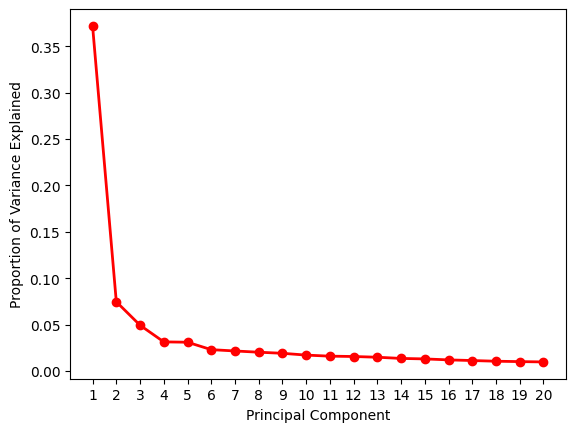

[[-0.05439598 -0.08641829 -0.08464649 ...  0.10917065  0.00322186
   0.04207031]
 [-0.02254194  0.12264549  0.12377492 ... -0.23330969  0.13397837
   0.27647122]
 [ 0.09476303  0.0168185   0.01633786 ...  0.1220739  -0.23489653
  -0.06184349]
 ...
 [ 0.04912542 -0.00461385 -0.0043509  ...  0.06725762  0.04047765
  -0.09226679]
 [ 0.0748895  -0.00794819 -0.00793573 ...  0.03759529 -0.22044489
   0.00178612]
 [-0.08644035  0.00912331  0.00999298 ...  0.01829198 -0.1627379
   0.02641906]]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load data
df = pd.read_csv('/content/f2_data.csv')

# separate features and target variable
X = df.iloc[:,0:87]
y = df.iloc[:,88]
# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
column_names = X.columns
X_std_df = pd.DataFrame(X_std, columns=column_names)
X_std_df.to_csv('standard.csv',index=False)

# Create a PCA object and fit it to the standardized data
pca = PCA(n_components=20)
pca.fit(X_std)
# Plot the scree plot to visualize the explained variance ratio
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.show()
print(pca.components_)


In [4]:
from sklearn.decomposition import PCA
import numpy as np

# Assuming you have your feature matrix stored in X

# Create an instance of PCA
pca = PCA(n_components=6)  # Specify the number of components you want to extract

# Fit the PCA model to the data
pca.fit(X_std)


# Access the loadings (coefficients) of the original features in the principal components
feature_loadings = pca.components_

# Get the indices of the features with highest absolute loadings for each principal component
selected_feature_indices = np.abs(feature_loadings).argmax(axis=1)

# Create labels for the features based on their column indices
pca_selected = [i for i in selected_feature_indices]


# Print the selected features
print("Selected Features:")
l=[]
for i in pca_selected:
  l.append(df.columns[i])
print(l)





Selected Features:
['Visual_disturbance', 'Sledai', 'Days_since_diagnosis', 'Subject', 'Neutrophil_count', 'Sledai_component_class']


In [5]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


# Fitness function (modify this according to your problem)
def fitness_function(individual):
    # Select features based on the individual's chromosome
    selected_features = [feature for feature, select in zip(X_std_df.columns, individual) if select]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_std_df[selected_features], y, test_size=0.2, random_state=42)

    # Train a classifier (e.g., Decision Tree) on the selected features
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test set
    y_pred = classifier.predict(X_test)

    # Calculate the fitness value (e.g., classification accuracy)
    fitness = accuracy_score(y_test, y_pred)

    # Penalize the fitness value based on the number of selected features
    fitness -= 0.01 * np.count_nonzero(individual)

    # Return the fitness value
    return fitness

# Initialization
def initialize_population(population_size, chromosome_length):
    population = []
    for _ in range(population_size):
        individual = [random.choice([True, False]) for _ in range(chromosome_length)]
        population.append(individual)
    return population

# Selection
def selection(population, fitness_scores):
    # Perform selection of parents based on fitness scores
    # You can implement your own selection strategy, such as tournament selection or roulette wheel selection
    # Here, we'll use tournament selection

    tournament_size = 2
    selected_parents = []
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitness)]
        selected_parents.append(population[winner_index])

    return selected_parents

# Crossover
def crossover(parent1, parent2):
    # Perform crossover between two parents to produce offspring
    # Here, we'll use single-point crossover

    crossover_point = random.randint(0, len(parent1) - 1)
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    return offspring1, offspring2

# Mutation
def mutation(individual, mutation_rate):
    # Perform mutation on an individual
    # Here, we'll use bit-flip mutation

    mutated_individual = individual.copy()
    for i in range(len(mutated_individual)):
        if random.random() < mutation_rate:
            mutated_individual[i] = not mutated_individual[i]  # Flip the bit

    return mutated_individual

# Genetic algorithm
def genetic_algorithm(population_size, chromosome_length, generations):
    population = initialize_population(population_size, chromosome_length)

    for _ in range(generations):
        # Evaluate the fitness of each individual in the population
        fitness_scores = [fitness_function(individual) for individual in population]

        # Select two parents for reproduction
        parents = selection(population, fitness_scores)
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)

        # Perform crossover to produce offspring
        offspring1, offspring2 = crossover(parent1, parent2)

        # Perform mutation on the offspring
        offspring1 = mutation(offspring1, mutation_rate)
        offspring2 = mutation(offspring2, mutation_rate)

        # Replace the least fit individuals in the population with the offspring
        least_fit_indices = np.argsort(fitness_scores)[:2]
        population[least_fit_indices[0]] = offspring1
        population[least_fit_indices[1]] = offspring2
    best_individual = population[np.argmax(fitness_scores)]
    selected_features = [feature for feature, select in zip(X_std_df.columns, best_individual) if select]
    return selected_features


# Example usage
population_size =100
chromosome_length = len(X_std_df.columns)  # Number of features
generations = 10
mutation_rate = 0.01
#max_selected_features = 10
selected_features = genetic_algorithm(population_size, chromosome_length, generations)
print("Selected features:", selected_features)

Selected features: ['Sourcename', 'Batch_replicate', 'Days_since_last_visit', 'Days_between_diagnosis_and_last_visit', 'Gender', 'Age', 'Biopsy_history', 'Wbc', 'Monocyte_count', 'Monocyte_percent', 'Platelet_count', 'Hgb', 'Mpv', 'Alb', 'C4', 'Cyclophosphamide_category', 'Vasculitis', 'Arthritis', 'Myositis', 'Hematuria', 'Proteinuria', 'Pyuria', 'New_rash', 'Thrombocytopenia', 'Leukopenia', 'Serology', 'Neph_treat_lmm3']


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Define your dataset X and labels y here
# Replace X and y with your dataset and target variable
X = df.iloc[:,0:88]
y = df.iloc[:,88]

# Define the number of features you want to select
n_features = 20  # Adjust this based on your requirements

# Define your optimization objective function
def optimization_objective(selected_features):
    # Create a mask for feature selection
    feature_mask = np.zeros(X.shape[1], dtype=bool)
    feature_mask[selected_features] = True

    # Split the dataset into training and testing sets using the mask
    X_selected = X.loc[:, feature_mask]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

    # Create a classifier (e.g., Decision Tree Classifier)
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    # Since COA minimizes the objective function, return the negative accuracy
    return -accuracy

# Coyote Optimization Algorithm for feature selection
def COA(FOBJ, nfevalMAX, n_features):
    # Define your COA algorithm parameters here
    # You may adjust these parameters as needed
    D = n_features  # Problem dimension (number of features)
    n_coyotes = 10  # Number of coyotes in a pack
    n_packs = 5  # Number of packs
    p_leave = 0.1  # Probability of leaving a pack
    Ps = 1/D  # Probability of selecting a feature
    VarMin = np.zeros(D)  # Lower boundaries for features
    VarMax = np.ones(D)  # Upper boundaries for features
    max_age = 10  # Maximum age of a coyote

    # Initialize coyotes
    coyotes = np.random.rand(n_packs, n_coyotes, D)  # Initialize coyotes randomly
    costs = np.zeros((n_packs, n_coyotes))
    ages = np.zeros((n_packs, n_coyotes))

    # Main loop
    for iteration in range(nfevalMAX):
        # Update coyotes
        for p in range(n_packs):
            for c in range(n_coyotes):
                # Evaluate the cost of each coyote's subset of features
                selected_features = np.where(coyotes[p, c] > 0.5)[0]
                costs[p, c] = FOBJ(selected_features)
                # Age the coyotes
                ages[p, c] += 1

        # Select alpha coyotes
        alpha_indices = np.unravel_index(np.argmin(costs, axis=None), costs.shape)
        alpha_costs = costs[alpha_indices]
        alpha_ages = ages[alpha_indices]

        # Update selected features
        alpha_features = np.where(coyotes[alpha_indices] > 0.5)[0]
        if alpha_costs < 0:
            print(f"Iteration {iteration}: Best accuracy = {-alpha_costs}, Age = {alpha_ages}")
            print("Selected Features:", alpha_features)

        # Update packs
        for p in range(n_packs):
            for c in range(n_coyotes):
                if np.random.random() < p_leave:
                    # Coyote leaves the pack
                    new_pack = np.random.randint(0, n_packs)
                    coyotes[new_pack, c] = coyotes[p, c]
                    costs[new_pack, c] = costs[p, c]
                    ages[new_pack, c] = ages[p, c]
                    coyotes[p, c] = np.random.rand(D)  # Replace coyote with a new one

        # Mutate coyotes
        for p in range(n_packs):
            for c in range(n_coyotes):
                random_pack = np.random.randint(0, n_packs)
                random_coyote = np.random.randint(0, n_coyotes)
                beta = 0.5
                F = 0.5
                r = np.random.rand(D)
                new_coyote = coyotes[p, c] + F * (coyotes[random_pack, random_coyote] - coyotes[p, c]) + beta * (coyotes[random_pack, random_coyote] - coyotes[p, c])
                new_coyote = np.minimum(1, np.maximum(0, new_coyote))
                coyotes[p, c] = new_coyote

    # Find the best alpha coyote
    best_alpha_pack, best_alpha_coyote = alpha_indices
    best_alpha_features = np.where(coyotes[best_alpha_pack, best_alpha_coyote] > 0.5)[0]
    best_alpha_cost = -alpha_costs
    return best_alpha_features, best_alpha_cost


# Call the COA algorithm to perform feature selection
nfevalmax = 50  # Maximum number of function evaluations
best_alpha_features, best_alpha_cost=COA(optimization_objective, nfevalmax, n_features)
print("\nBest Alpha Coyote (Final):")
print("Selected Features:", best_alpha_features)
print("Accuracy:", best_alpha_cost)
coyote=[]
for i in best_alpha_features:
  coyote.append(df.columns[i])
print(coyote)
final=pd.DataFrame(X_std_df, columns=coyote)
final.to_csv('Final',index=False)


Iteration 0: Best accuracy = 1.0, Age = 1.0
Selected Features: [ 0  3  5  7 10 12 17 18 19]
Iteration 1: Best accuracy = 1.0, Age = 2.0
Selected Features: [ 0  1  4  5  7 10 11 13 15 16 17]
Iteration 2: Best accuracy = 1.0, Age = 3.0
Selected Features: [ 0  2  3  4  8  9 11 14 17 18 19]
Iteration 3: Best accuracy = 1.0, Age = 4.0
Selected Features: [ 0  2  3  5  6 10 12 13 14 15 16 17]
Iteration 4: Best accuracy = 1.0, Age = 5.0
Selected Features: [ 8 11 14 16 17 19]
Iteration 5: Best accuracy = 1.0, Age = 6.0
Selected Features: [ 0  2  7  9 10 11 13 14 17]
Iteration 6: Best accuracy = 1.0, Age = 7.0
Selected Features: [ 0  2  7  9 10 11 13 14 17]
Iteration 7: Best accuracy = 1.0, Age = 8.0
Selected Features: [ 0  2  3  5  6 10 12 13 14 15 16 17]
Iteration 8: Best accuracy = 1.0, Age = 9.0
Selected Features: [ 0  2  3  5  6 10 12 13 14 15 16 17]
Iteration 9: Best accuracy = 1.0, Age = 10.0
Selected Features: [ 0  2  3  5  6 10 12 13 14 15 16 17]
Iteration 10: Best accuracy = 1.0, Age =

In [7]:
from sklearn import model_selection
df=pd.read_csv('/content/f2_data.csv')
columns=selected_features # GA
c1=['Ds_dna','Days_between_diagnosis_and_last_visit','Days_since_kidney_biopsy','Title','Cumulative_time','Accession'] #PCA
X_pca = np.array(X_std_df[c1])
X_ga=np.array(X_std_df[columns])
X_coyote=np.array(df[coyote])
y = np.array(df['Diseasestate'])
t_train,t_test,T_train,T_test=model_selection.train_test_split(X_pca,y,test_size=0.3,random_state=42)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_coyote, y, test_size = 0.3,random_state=42)
x_train, x_test, Y_train, Y_test = model_selection.train_test_split(X_ga, y, test_size = 0.3,random_state=42)



Epoch 1/10
22/22 [==============================] - 1s 16ms/step - loss: 1.1729 - accuracy: 0.2898 - val_loss: 1.0002 - val_accuracy: 0.6421
Epoch 2/10
22/22 [==============================] - 0s 4ms/step - loss: 0.9601 - accuracy: 0.6141 - val_loss: 0.8488 - val_accuracy: 0.9097
Epoch 3/10
22/22 [==============================] - 0s 4ms/step - loss: 0.8340 - accuracy: 0.8164 - val_loss: 0.7389 - val_accuracy: 0.9197
Epoch 4/10
22/22 [==============================] - 0s 4ms/step - loss: 0.7278 - accuracy: 0.8809 - val_loss: 0.6428 - val_accuracy: 0.9197
Epoch 5/10
22/22 [==============================] - 0s 5ms/step - loss: 0.6408 - accuracy: 0.9110 - val_loss: 0.5649 - val_accuracy: 0.9197
Epoch 6/10
22/22 [==============================] - 0s 4ms/step - loss: 0.5888 - accuracy: 0.9197 - val_loss: 0.5018 - val_accuracy: 0.9197
Epoch 7/10
22/22 [==============================] - 0s 4ms/step - loss: 0.5158 - accuracy: 0.9254 - val_loss: 0.4496 - val_accuracy: 0.9197
Epoch 8/10
22/22 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.9197324514389038


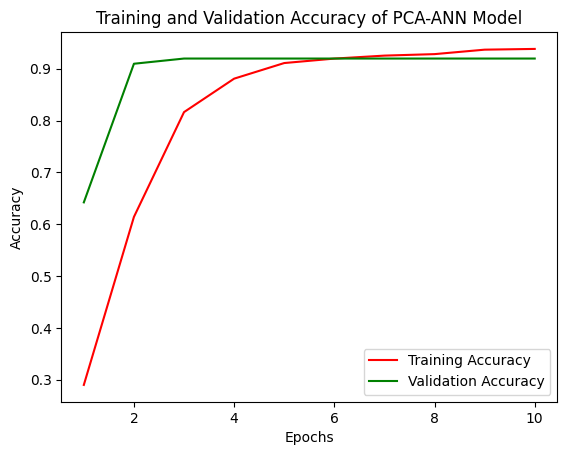

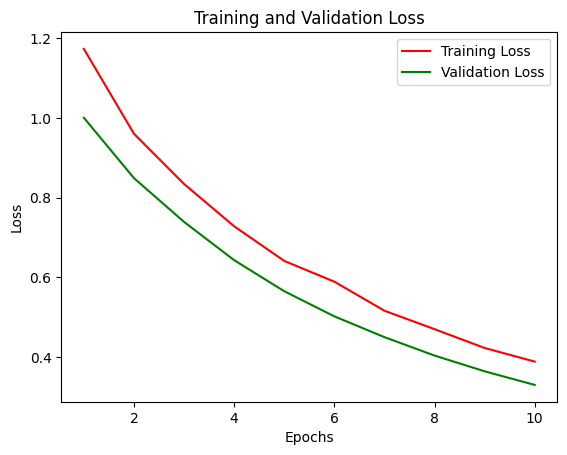

In [8]:
# PCA-ANN Model

from keras.models import Sequential, load_model
from keras.utils import plot_model

from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_binary_model():
    model = Sequential()
    model.add(Dense(32, input_dim=6, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

pca_model = create_binary_model()
plot_model(pca_model, to_file='model_architecture.png', show_shapes=True)


# add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = pca_model.fit(t_train, T_train, epochs=10, batch_size=32, validation_data=(t_test, T_test), callbacks=[early_stopping])
pca_model.save("Trained_model.h5")
# evaluate the model on the test set
loss, accuracy = pca_model.evaluate(t_test, T_test)
print("Test accuracy:", accuracy)

# Retrieve accuracy and loss values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, 'r', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of PCA-ANN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the accuracy plot
plt.show()

# Plot loss
plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the loss plot
plt.show()


10/10 [==============================] - 0s 2ms/step


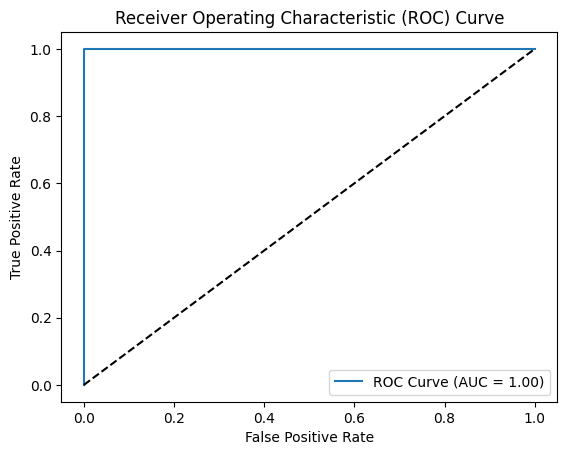

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the predicted class probabilities in `y_pred_prob` and the true labels in `y_true`
y_pred_prob = pca_model.predict(t_test)
fpr, tpr, thresholds = roc_curve(T_test, y_pred_prob)

# Compute the AUC score
auc_score = roc_auc_score(T_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



10/10 [==============================] - 0s 3ms/step


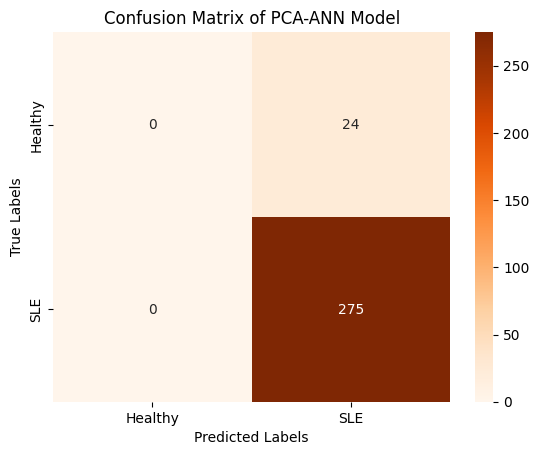

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your predicted labels and true labels
y_pred = pca_model.predict(t_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = T_test
conf_matrix = confusion_matrix(y_true, y_pred_classes)

label_dict= {0: 'Healthy', 1: 'SLE'}
#cmap = sns.dark_palette("darkslategray", as_cmap=True)

ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")

plt.xticks(np.arange(2) + 0.5, label_dict.values())
plt.yticks(np.arange(2) + 0.5, label_dict.values())

plt.title("Confusion Matrix of PCA-ANN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()



In [11]:
from sklearn.metrics import classification_report

# Assuming you have your predicted labels and true labels
y_pred = pca_model.predict(t_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = T_test
# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1score = f1_score(y_true, y_pred_classes)



print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)

# Generate classification report
target_names = ['Healthy', 'SLE']
report = classification_report(y_true, y_pred_classes, target_names=target_names)

print("Classification Report:\n", report)


10/10 [==============================] - 0s 2ms/step
Precision: 0.919732441471572
Recall: 1.0
F1-score: 0.9581881533101045
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        24
         SLE       0.92      1.00      0.96       275

    accuracy                           0.92       299
   macro avg       0.46      0.50      0.48       299
weighted avg       0.85      0.92      0.88       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
11/11 [==============================] - 1s 35ms/step - loss: 1.3273 - accuracy: 0.5667 - val_loss: 1.0337 - val_accuracy: 0.8896
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 1.2322 - accuracy: 0.6413 - val_loss: 0.9590 - val_accuracy: 0.9599
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 1.1509 - accuracy: 0.6743 - val_loss: 0.8962 - val_accuracy: 0.9866
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 1.0344 - accuracy: 0.7604 - val_loss: 0.8435 - val_accuracy: 0.9933
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 1.0400 - accuracy: 0.7446 - val_loss: 0.7982 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.9352 - accuracy: 0.7977 - val_loss: 0.7578 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.9493 - accuracy: 0.7977 - val_loss: 0.7183 - val_accuracy: 1.0000
Epoch 8/10
11/1

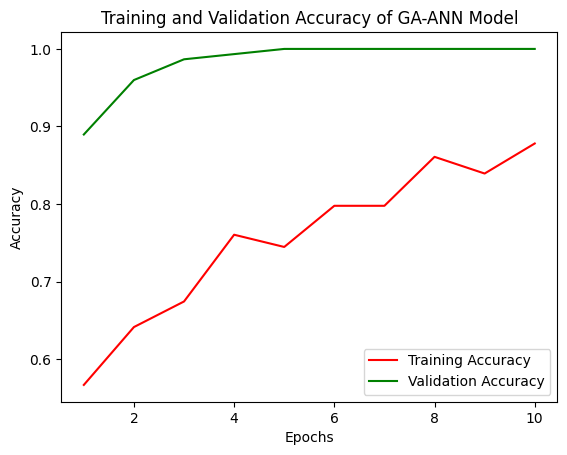

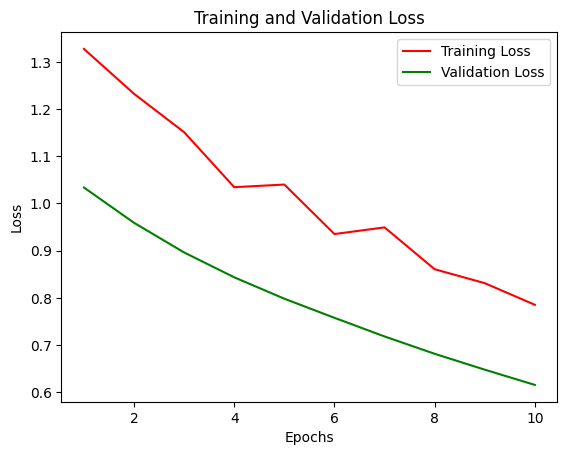

In [12]:
# GA-ANN Model

from keras.models import Sequential, load_model
from keras.utils import plot_model

from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_binary_model():
    model = Sequential()
    model.add(Dense(32, input_dim=len(selected_features), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.7))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

ga_model = create_binary_model()
plot_model(ga_model, to_file='model_architecture.png', show_shapes=True)


# add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = ga_model.fit(x_train, Y_train, epochs=10, batch_size=64, validation_data=(x_test, Y_test), callbacks=[early_stopping])
# evaluate the model on the test set
loss, accuracy = ga_model.evaluate(x_test, Y_test)
print("Test accuracy:", accuracy)

# Retrieve accuracy and loss values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, 'r', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of GA-ANN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the accuracy plot
plt.show()

# Plot loss
plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the loss plot
plt.show()


10/10 [==============================] - 0s 3ms/step


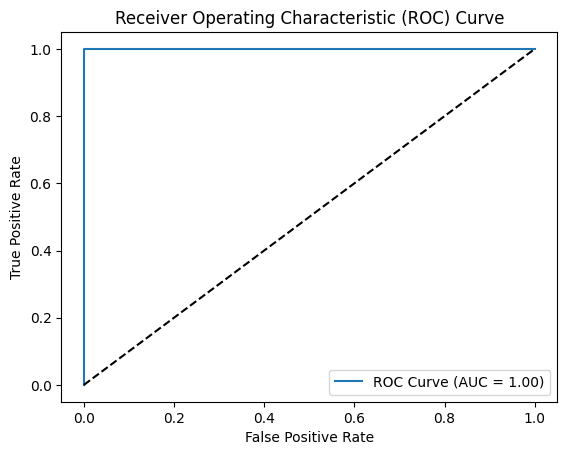

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the predicted class probabilities in `y_pred_prob` and the true labels in `y_true`
y_pred_prob = ga_model.predict(x_test)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

# Compute the AUC score
auc_score = roc_auc_score(Y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



10/10 [==============================] - 0s 2ms/step


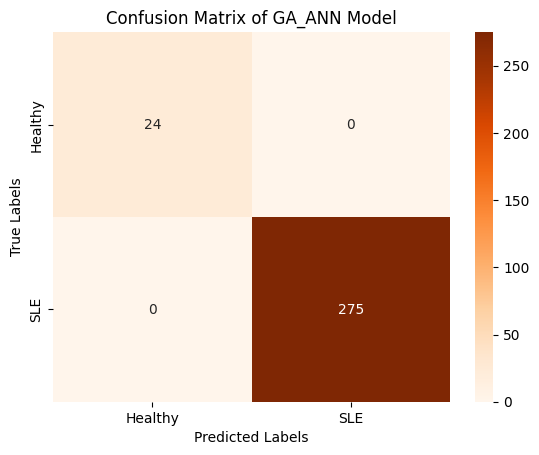

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your predicted labels and true labels
y_pred = ga_model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = Y_test
conf_matrix = confusion_matrix(y_true, y_pred_classes)

label_dict= {0: 'Healthy', 1: 'SLE'}
#cmap = sns.dark_palette("darkslategray", as_cmap=True)

ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")

plt.xticks(np.arange(2) + 0.5, label_dict.values())
plt.yticks(np.arange(2) + 0.5, label_dict.values())

plt.title("Confusion Matrix of GA_ANN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()



In [15]:
from sklearn.metrics import classification_report

# Assuming you have your predicted labels and true labels
y_pred = ga_model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = Y_test
# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1score = f1_score(y_true, y_pred_classes)



print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)

# Generate classification report
target_names = ['Healthy', 'SLE']
report = classification_report(y_true, y_pred_classes, target_names=target_names)

print("Classification Report:\n", report)


10/10 [==============================] - 0s 3ms/step
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        24
         SLE       1.00      1.00      1.00       275

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



Epoch 1/20
22/22 [==============================] - 1s 13ms/step - loss: 47.2502 - accuracy: 0.7489 - val_loss: 3.8019 - val_accuracy: 0.8863
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 17.5301 - accuracy: 0.8537 - val_loss: 1.1075 - val_accuracy: 0.9130
Epoch 3/20
22/22 [==============================] - 0s 4ms/step - loss: 9.9503 - accuracy: 0.8881 - val_loss: 0.8583 - val_accuracy: 0.9197
Epoch 4/20
22/22 [==============================] - 0s 4ms/step - loss: 7.1316 - accuracy: 0.9053 - val_loss: 1.0000 - val_accuracy: 0.9197
Epoch 5/20
22/22 [==============================] - 0s 4ms/step - loss: 4.0435 - accuracy: 0.9154 - val_loss: 1.0512 - val_accuracy: 0.9197
Epoch 6/20
22/22 [==============================] - 0s 4ms/step - loss: 5.6161 - accuracy: 0.8996 - val_loss: 1.0941 - val_accuracy: 0.9197
Epoch 7/20
22/22 [==============================] - 0s 4ms/step - loss: 4.4896 - accuracy: 0.9125 - val_loss: 1.1400 - val_accuracy: 0.9197
Epoch 8/20
22/22 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 2ms/step - loss: 1.1121 - accuracy: 0.9197
Test accuracy: 0.9197324514389038


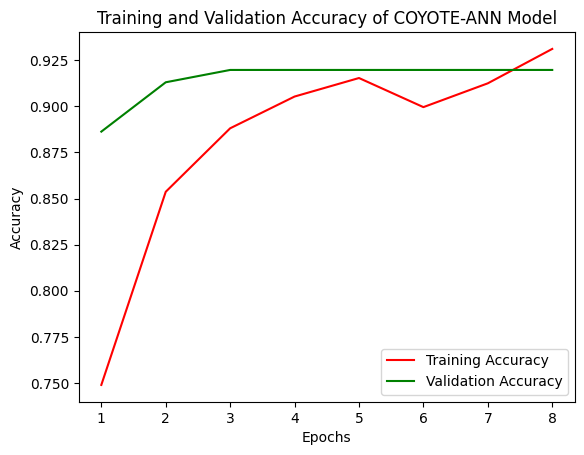

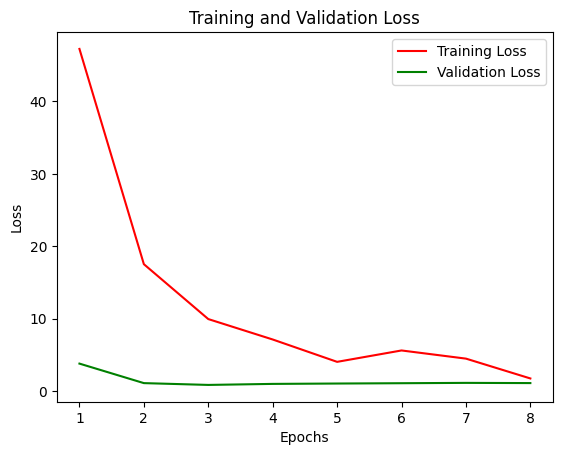

In [16]:
# COYOTE-ANN Model

from keras.models import Sequential, load_model
from keras.utils import plot_model

from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_binary_model():
    model = Sequential()
    model.add(Dense(32, input_dim=len(coyote), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

Coyote_model = create_binary_model()
plot_model(Coyote_model, to_file='model_architecture.png', show_shapes=True)


# add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = Coyote_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
Coyote_model.save("ga.h5")
# evaluate the model on the test set
loss, accuracy = Coyote_model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

# Retrieve accuracy and loss values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, 'r', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of COYOTE-ANN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the accuracy plot
plt.show()

# Plot loss
plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the loss plot
plt.show()

10/10 [==============================] - 0s 2ms/step


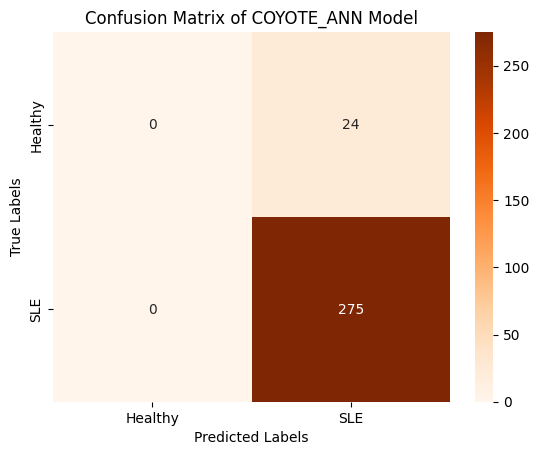

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your predicted labels and true labels
y_pred = Coyote_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = y_test
conf_matrix = confusion_matrix(y_true, y_pred_classes)

label_dict= {0: 'Healthy', 1: 'SLE'}
#cmap = sns.dark_palette("darkslategray", as_cmap=True)

ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")

plt.xticks(np.arange(2) + 0.5, label_dict.values())
plt.yticks(np.arange(2) + 0.5, label_dict.values())

plt.title("Confusion Matrix of COYOTE_ANN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

In [18]:
from sklearn.metrics import classification_report

# Assuming you have your predicted labels and true labels
y_pred = Coyote_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = y_test
# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1score = f1_score(y_true, y_pred_classes)



print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)

# Generate classification report
target_names = ['Healthy', 'SLE']
report = classification_report(y_true, y_pred_classes, target_names=target_names)

print("Classification Report:\n", report)


10/10 [==============================] - 0s 2ms/step
Precision: 0.919732441471572
Recall: 1.0
F1-score: 0.9581881533101045
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        24
         SLE       0.92      1.00      0.96       275

    accuracy                           0.92       299
   macro avg       0.46      0.50      0.48       299
weighted avg       0.85      0.92      0.88       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
